# **Time Series Generator**

This script will make you able to generate a chosen number of time series of random stocks at random period of time.


In [1]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from fastpip import pip
import math
%matplotlib inline

For Colab, it downloads the data using the following code. 

If you work locally be sure to have the folder *data/*. You can download it from the repo.

In [2]:
try:
  from google.colab import files
  !wget -q https://github.com/Amelrich/Capstone-Fall-2020/archive/master.zip
  !unzip -q master.zip
  !mv Capstone-Fall-2020-master/data/ data/
  !rm -rf master.zip Capstone-Fall-2020-master/
except:
  print("only in Colab")

only in Colab


## The generator

It generates random timeseries picked from random stocks at random times.

Currently you can access to the generated time series using the method `get_list_of_df` (see example below). Next improvements will allow to choose a wider range of structures like arrays etc.



In [3]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[rd.randint(len(self.symbols))]
      TS = pd.read_csv('data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = rd.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

# Data Preprocessing

In [4]:
def reduce_dimension(context, dim):
    embed_matrix = np.empty(shape=[0, dim])
    # Going through each row of the context scale and reduce its dimension
    for i in range(context.shape[0]):
        x = np.arange(1, context.shape[1] + 1)  
        y = context_matrix[i,:]
        sample = [(a,b) for a, b in zip(x,y)]
        reduce_sample = pip(sample, dim)
        result = [a[1] for a in reduce_sample]
        embed_matrix = np.append(embed_matrix, np.asarray(result).reshape(1,-1), axis =0)
    return embed_matrix

In [5]:
def normalize(matrix):
    norm_matrix = matrix
    for row in range(matrix.shape[0]):
        norm_matrix[row,:] = (matrix[row,:]-np.mean(matrix[row,:]))/np.std(matrix[row,:])
    return norm_matrix

In [6]:
context_scale = 100
current_scale = 30
gen = TS_generator(nb_timeseries=500, chunk_size=context_scale) #default values but just for the syntax
context_matrix = gen.get_array()
current_matrix = context_matrix[:, context_scale - current_scale:]

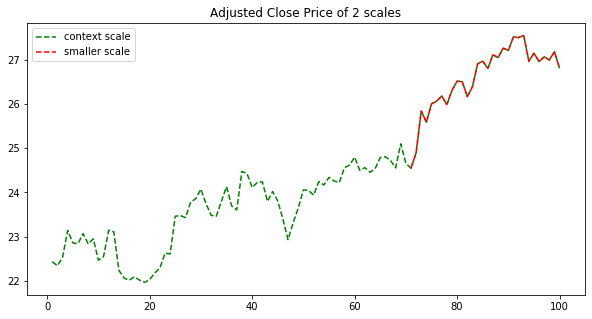

In [7]:
fig,ax = plt.subplots(figsize=(10,5))
x = np.arange(1, context_scale + 1)  
y = context_matrix[10,:]
plt.plot(x, y, color ="green", linestyle='dashed', label='context scale');
x1 = np.arange(context_scale - current_scale + 1, context_scale + 1)  
y1 = current_matrix[10,:]
plt.plot(x1, y1, color ="red", linestyle='dashed', label='smaller scale');
plt.legend();
plt.title("Adjusted Close Price of 2 scales");

In [8]:
context_embed = reduce_dimension(normalize(context_matrix), current_scale)
X_train = np.append(context_embed, normalize(current_matrix), axis = 1)

# KMeans Clustering

In [9]:
from tslearn.clustering import TimeSeriesKMeans
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
model.fit(X_train)

TimeSeriesKMeans(n_clusters=10)

In [11]:
y_train_pred = model.predict(X_train)

/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


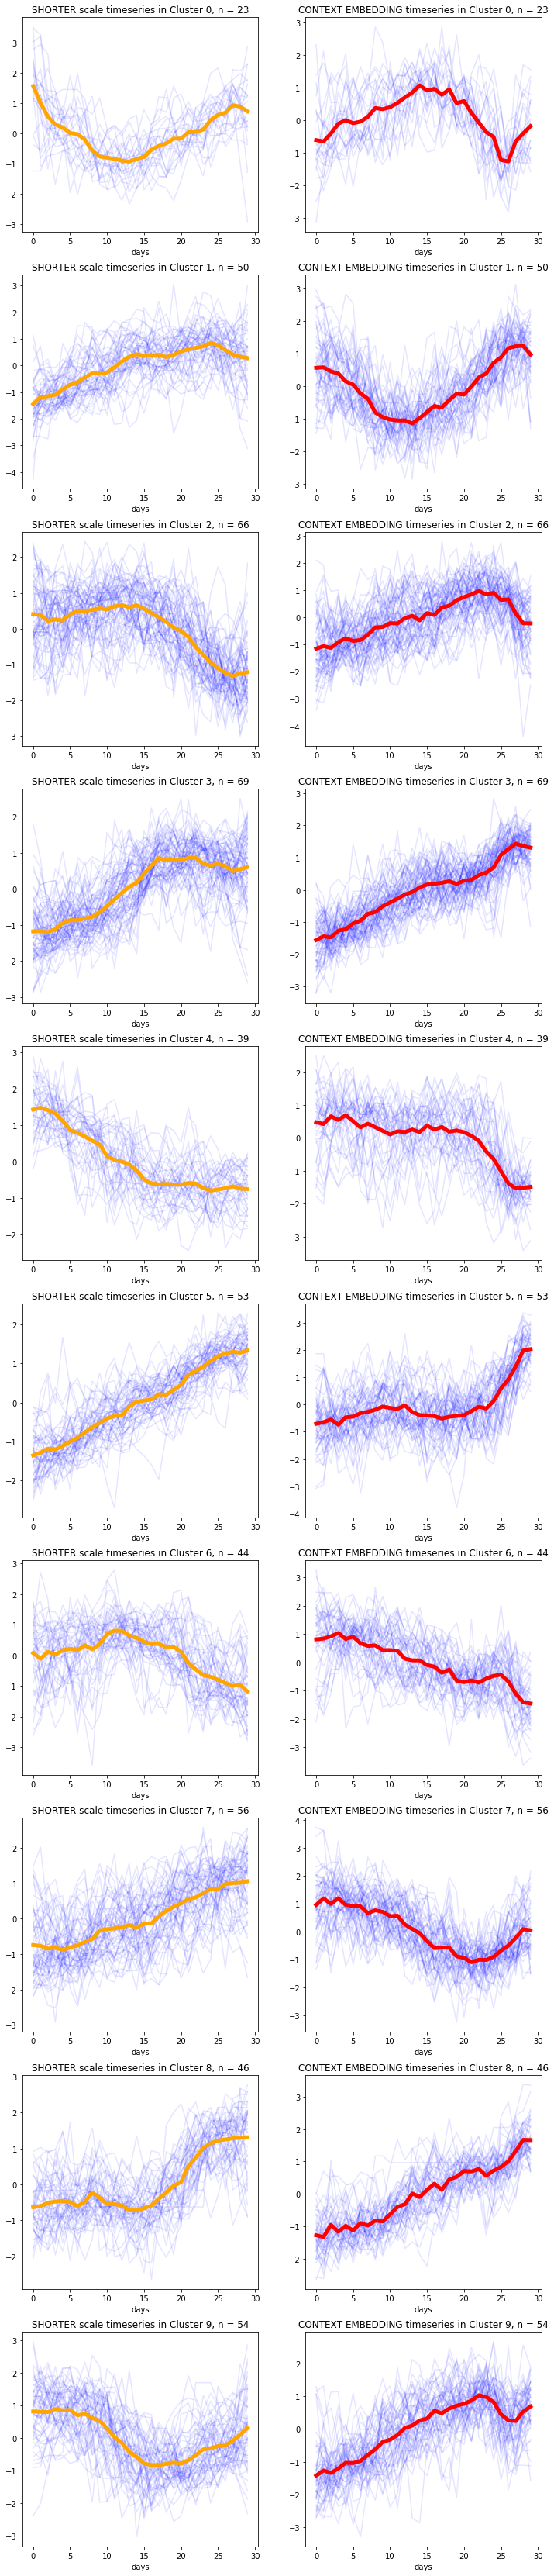

In [12]:
ncols = 2
nrows = n_clusters
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 6*nrows), squeeze=False)

for cluster in range(n_clusters): 
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
    # TRUE time series values
    current_mean = np.mean(X_train[indices,:], axis=0)[current_scale:]
    context_mean = np.mean(X_train[indices,:], axis=0)[:current_scale]
    #context_mean = np.mean(normalize(context_matrix)[indices,:], axis=0)
    current_count = 0
    context_count = 0
    for i in range(len(indices)):
        axes[cluster,1].plot(X_train[indices[i]][:current_scale],alpha=0.1, color='blue')
        #axes[cluster,1].plot(normalize(context_matrix)[indices[i]], alpha = 0.1, color = 'blue')
        axes[cluster,0].plot(X_train[indices[i]][current_scale:],alpha=0.1, color='blue')
        current_count += 1
        context_count += 1
    axes[cluster,1].plot(context_mean,color='red',linewidth=5,alpha=1)
    axes[cluster,1].title.set_text('CONTEXT EMBEDDING timeseries in Cluster '+str(cluster) + ", n = " +str(context_count))
    axes[cluster,1].set_xlabel("days")
    #axes[cluster,1].axvline(x=current_scale - math.ceil(context_scale/current_scale)*2, color='b', linestyle='-')
    axes[cluster,0].plot(current_mean,color='orange',linewidth=5,alpha=1)
    axes[cluster,0].title.set_text('SHORTER scale timeseries in Cluster '+str(cluster)+ ", n = " +str(current_count))
    axes[cluster,0].set_xlabel("days")
    
fig.savefig('test.jpg')

In [13]:
gen = TS_generator(nb_timeseries=1, chunk_size=70) #default values but just for the syntax
two_months = gen.get_array()

# Dynamic Time Warping on Combine 2 scales

In [14]:
from tslearn.clustering import TimeSeriesKMeans
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters, metric = 'dtw')

In [15]:
model.fit(X_train)
y_train_pred = model.predict(X_train)

/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


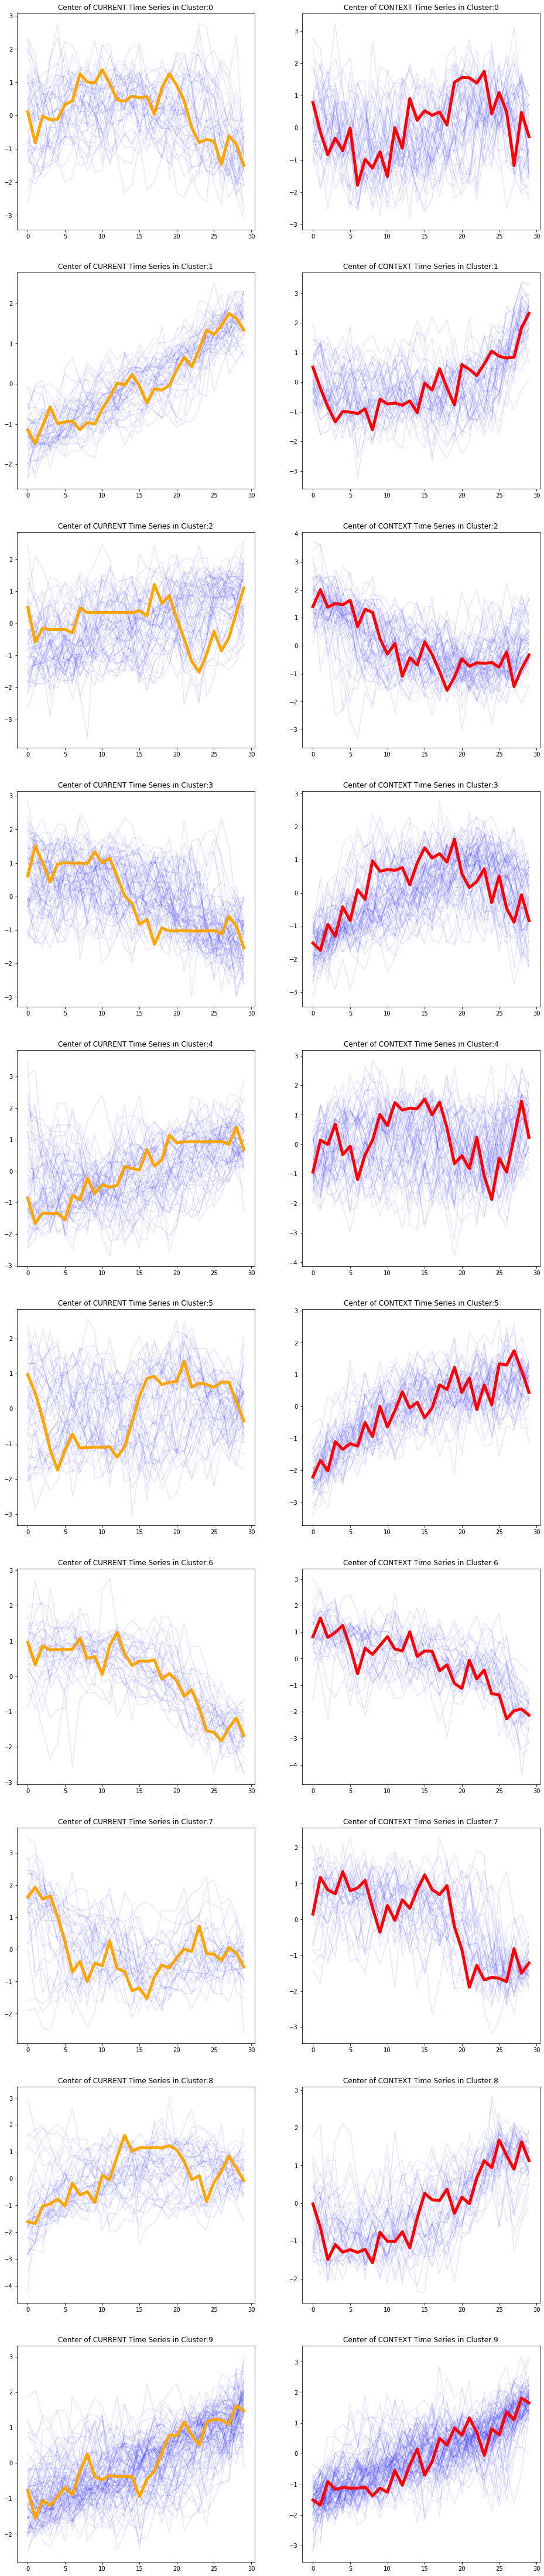

In [16]:
ncols = 2
nrows = n_clusters
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), squeeze=False)

for cluster in range(n_clusters): 
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
    # TRUE time series values
    current_center = model.cluster_centers_[cluster][current_scale:]
    context_center = model.cluster_centers_[cluster][:current_scale]
    
    for i in range(len(indices)):
        axes[cluster,1].plot(X_train[indices[i]][:current_scale],alpha=0.1, color='blue')
        axes[cluster,0].plot(X_train[indices[i]][current_scale:],alpha=0.1, color='blue')
    
    axes[cluster,1].plot(context_center,color='red',linewidth=5,alpha=1)
    axes[cluster,1].title.set_text('Center of CONTEXT Time Series in Cluster:'+str(cluster))
    
    axes[cluster,0].plot(current_center,color='orange',linewidth=5,alpha=1)
    axes[cluster,0].title.set_text('Center of CURRENT Time Series in Cluster:'+str(cluster))

# K-shape

In [17]:
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [18]:
context_embed = reduce_dimension(normalize(context_matrix), current_scale)
X_train = np.append(context_embed, normalize(current_matrix), axis = 1)

In [19]:
X_train.shape

(500, 60)

In [20]:
n_clusters = 10
ks = KShape(n_clusters=n_clusters, verbose=True, random_state=40)
y_train_pred = ks.fit_predict(X_train)

0.142 --> 0.132 --> 0.131 --> 0.133 --> 


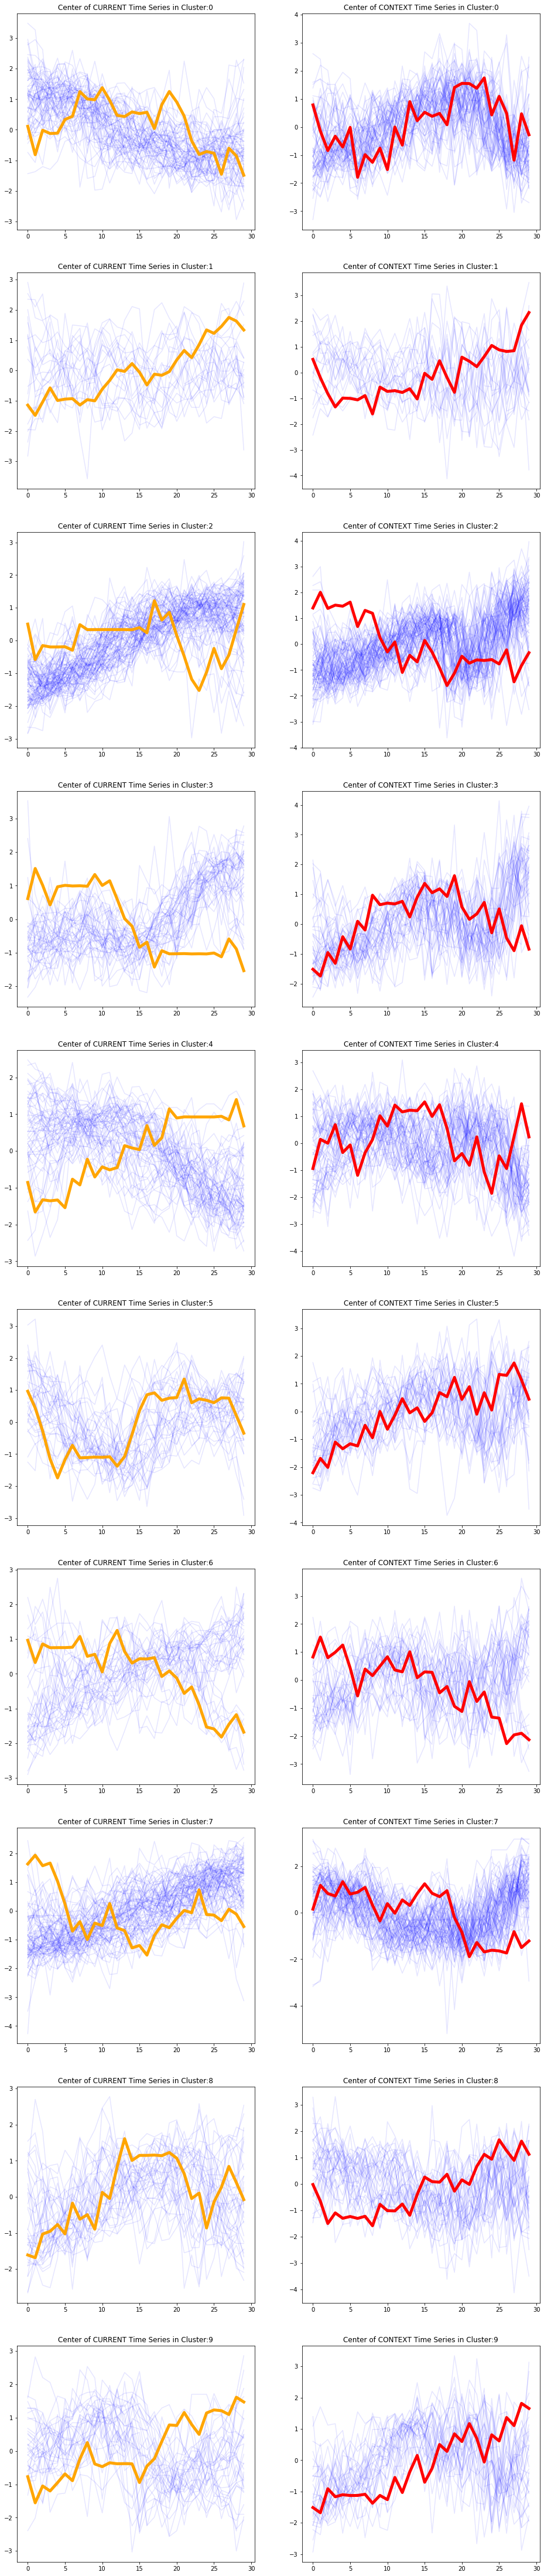

In [21]:
ncols = 2
nrows = n_clusters
fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows), squeeze=False)

for cluster in range(n_clusters): 
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
    # TRUE time series values
    current_center = model.cluster_centers_[cluster][current_scale:]
    context_center = model.cluster_centers_[cluster][:current_scale]
    
    for i in range(len(indices)):
        axes[cluster,1].plot(X_train[indices[i]][:current_scale],alpha=0.1, color='blue')
        axes[cluster,0].plot(X_train[indices[i]][current_scale:],alpha=0.1, color='blue')
        current_count += 1
        context_count += 1
        
    axes[cluster,1].plot(context_center,color='red',linewidth=5,alpha=1)
    axes[cluster,1].title.set_text('Center of CONTEXT Time Series in Cluster:'+str(cluster))
    
    axes[cluster,0].plot(current_center,color='orange',linewidth=5,alpha=1)
    axes[cluster,0].title.set_text('Center of CURRENT Time Series in Cluster:'+str(cluster))

# Naftali and Srijan suggestions

### Clustering on PIP embedding and then just plot its shorter scale time series right next to it

In [22]:
n_clusters = 10
model = TimeSeriesKMeans(n_clusters=n_clusters, metric = 'dtw')

In [23]:
model.fit(context_embed)
y_train_pred = model.predict(context_embed)

/opt/anaconda3/lib/python3.7/site-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 500 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


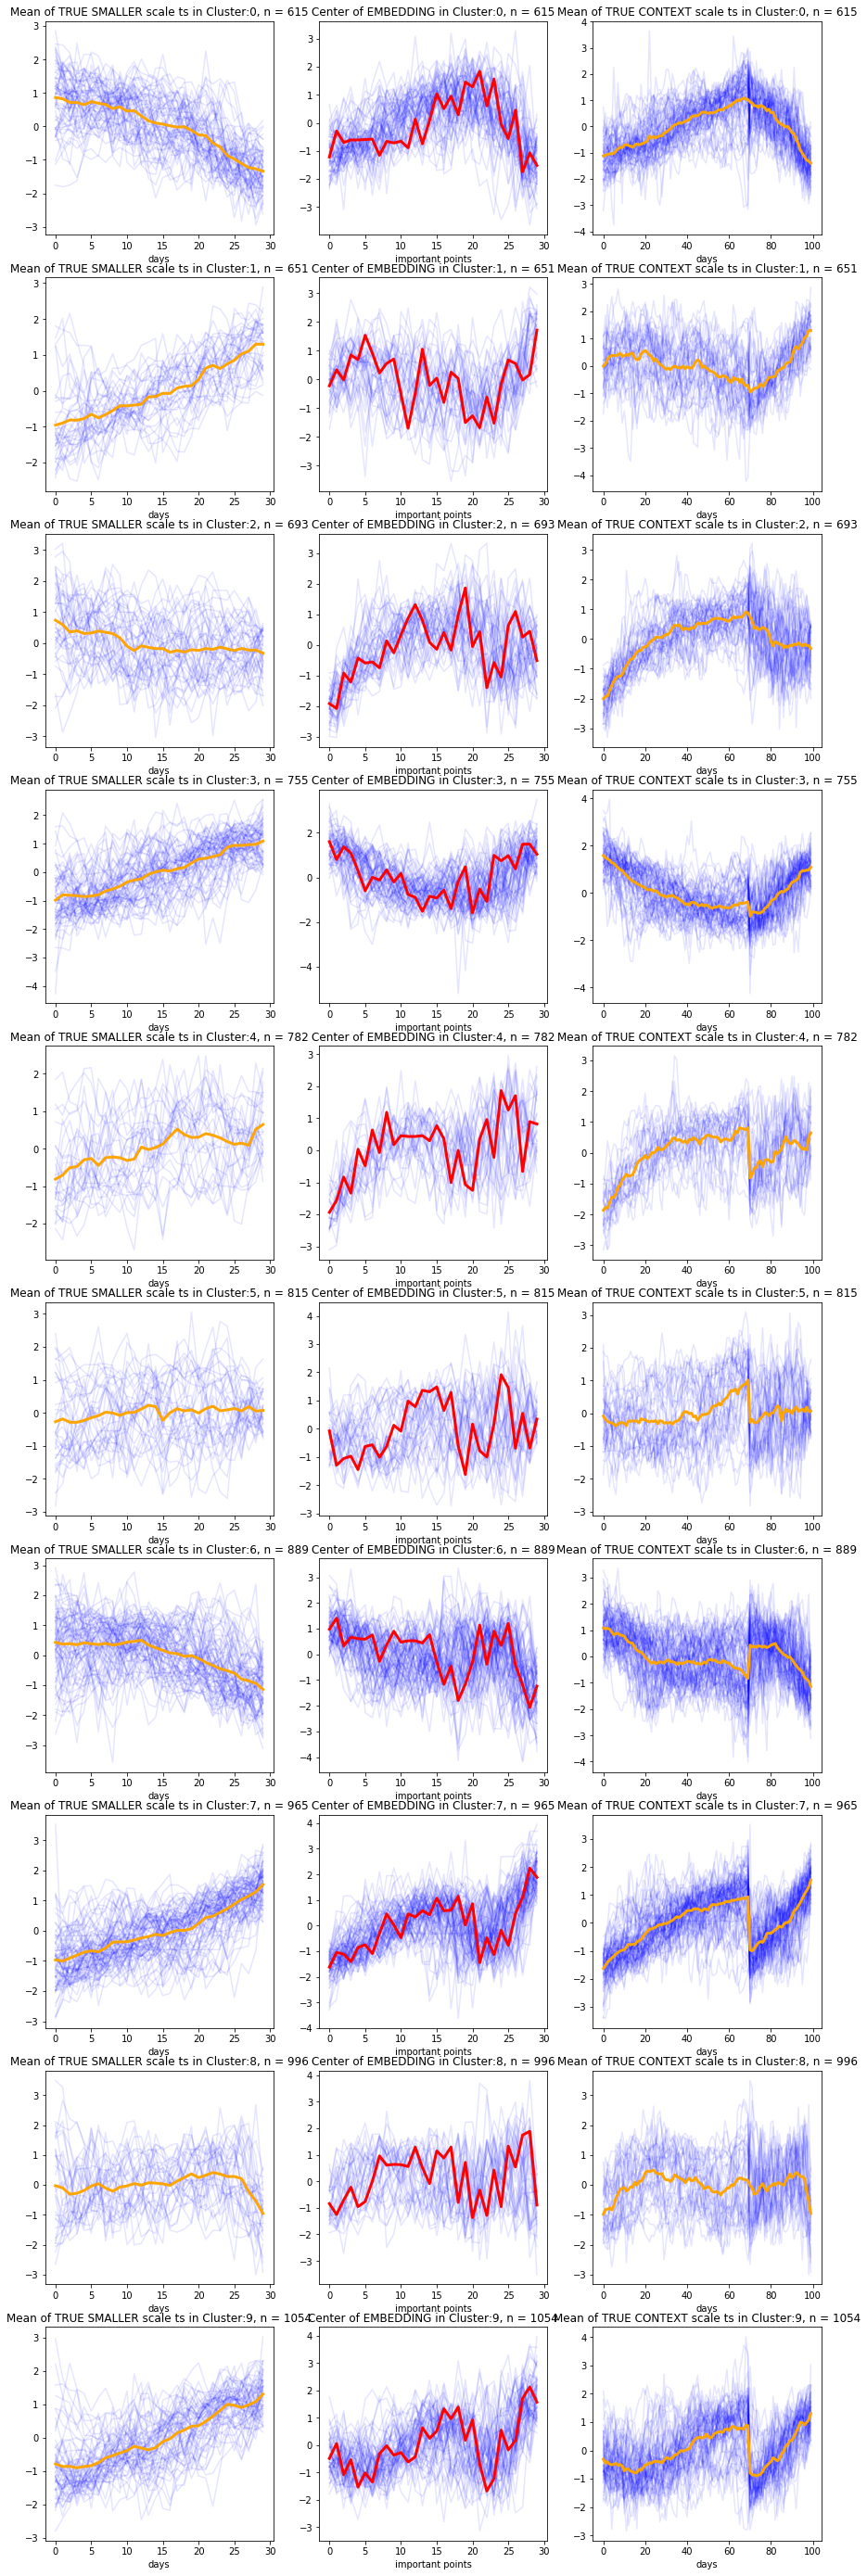

In [24]:
ncols = 3
nrows = n_clusters
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows), squeeze = False)
for cluster in range(n_clusters):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster]
    context_center = model.cluster_centers_[cluster]
    current_mean = np.mean(normalize(current_matrix)[indices,:], axis=0)
    context_mean = np.mean(normalize(context_matrix)[indices,:], axis=0)
    for i in range (len(indices)):
        axes[cluster,1].plot(context_embed[indices[i]],alpha=0.1, color='blue')
        axes[cluster,0].plot(normalize(current_matrix)[indices[i]], alpha = 0.1, color = 'blue')
        axes[cluster,2].plot(normalize(context_matrix)[indices[i]], alpha = 0.1, color = 'blue')
        current_count += 1
        context_count += 1
        
    axes[cluster,1].plot(context_center, color = 'red', linewidth = 3, alpha = 1)
    axes[cluster,1].title.set_text('Center of EMBEDDING in Cluster:'+str(cluster)+ ", n = " +str(context_count))
    axes[cluster,1].set_xlabel("important points")
    axes[cluster,0].plot(current_mean, color='orange', linewidth = 3, alpha = 1)
    axes[cluster,0].title.set_text('Mean of TRUE SMALLER scale ts in Cluster:'+str(cluster)+ ", n = " +str(context_count))
    axes[cluster,0].set_xlabel("days")
    axes[cluster,2].plot(context_mean, color='orange', linewidth = 3, alpha = 1)
    axes[cluster,2].title.set_text('Mean of TRUE CONTEXT scale ts in Cluster:'+str(cluster)+ ", n = " +str(context_count))
    axes[cluster,2].set_xlabel("days")
    

In [25]:
indices = [i for i,x in enumerate(y_train_pred) if x == 2]

In [26]:
normalize(current_matrix)[indices,:]

array([[-0.17192624,  0.05232638,  0.20757718, ..., -1.26730541,
        -0.66355267, -1.68993002],
       [-2.07594297, -1.66728254, -1.2671314 , ..., -0.5519752 ,
        -1.60768383, -1.69282282],
       [ 0.49707676,  0.33677944, -0.65712772, ..., -1.08642727,
        -0.41129813, -1.1078617 ],
       ...,
       [-1.71871923, -1.71871923, -1.03209551, ..., -1.16165187,
        -1.64121017, -0.64320669],
       [ 0.34618123,  0.48160248,  1.04408676, ..., -0.56007518,
        -0.24755738,  0.55451506],
       [ 0.63489539, -0.02824777, -0.17561005, ...,  0.67173273,
        -0.06508511, -0.54401574]])

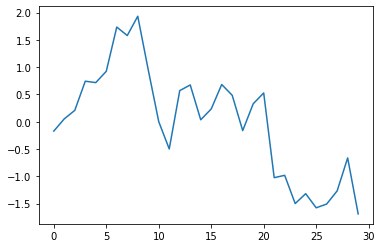

In [27]:
plt.plot(normalize(current_matrix)[indices,:][0,:])

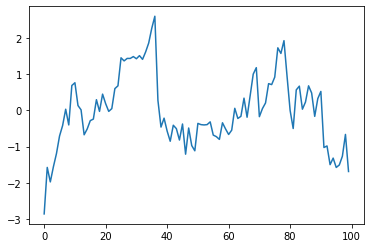

In [28]:
plt.plot(normalize(context_matrix)[indices,:][0,:])

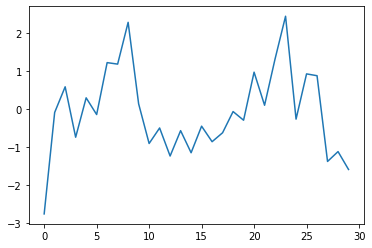

In [29]:
plt.plot(context_embed[indices,:][0,:])